In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
# from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
import pingouin as pg
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [132]:
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_set_crossval_random_state_1/"
results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_keep_units_consistent_0/"

In [3]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    # pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [4]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [136]:
### make separate query to include repeats - specify session
# sel_session='742903_2024-10-22' #the golden session
sel_session='664851_2023-11-13'
predict_proba_with_repeats_single_session = (
    pl.scan_parquet(results_path)
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
        pl.col('session_id').eq(sel_session),
    )#.drop('unit_ids') 
    # .sort('session_id', descending=True)
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='inner',
    )
    .with_columns(
        pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'trial_index')
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .select('session_id', 'trial_index', 'is_vis_context', 'stim_name', 'is_response', 'trial_index_in_block', 'block_index')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'repeat_idx', 'bin_center', 'unit_ids')
    .agg(
        pl.col('balanced_accuracy_test', 'total_n_units').first(),
        pl.col('predict_proba', 'trial_index', 'is_vis_context', 'stim_name', 'is_response', 'trial_index_in_block', 'block_index'),
    )
    .sort('session_id','structure', 'unit_subsample_size', 'repeat_idx', 'bin_center')
    # .group_by('session_id','structure')
    .collect()
)

In [137]:
predict_proba_with_repeats_single_session_pd = predict_proba_with_repeats_single_session.to_pandas()
# predict_proba_with_repeats_single_session_pd

In [131]:
# predict_proba_with_repeats_single_session_pd_fixed_crossval = predict_proba_with_repeats_single_session_pd.copy()

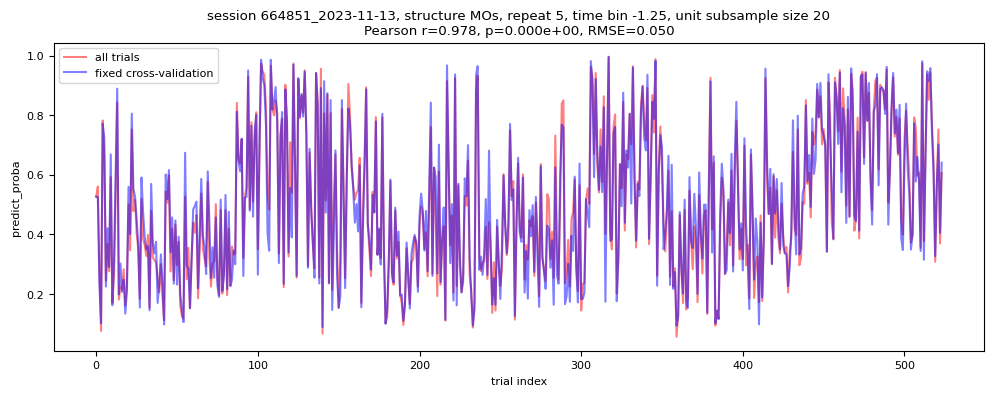

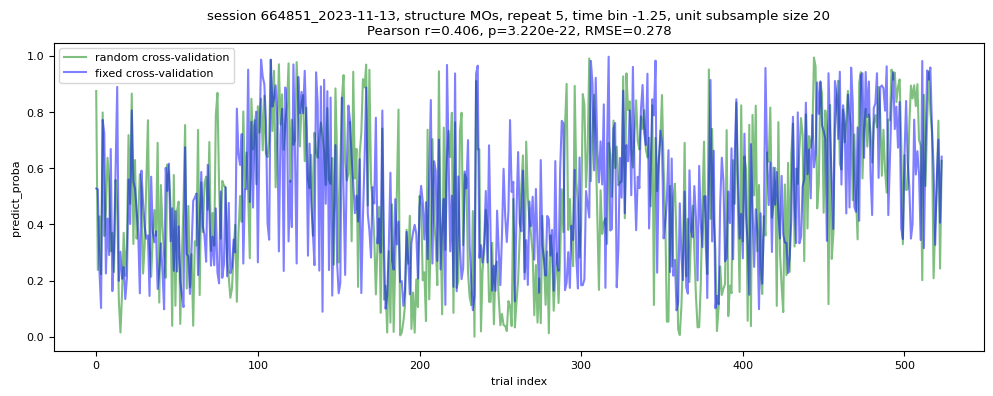

In [178]:
sel_structure='MOs'
sel_repeat_idx=5
sel_time_bin=-1.25
sel_unit_subsample_size=20

if np.isnan(sel_unit_subsample_size):
    filtered_df=predict_proba_with_repeats_single_session_pd_fixed_crossval.query(
        'structure == @sel_structure and repeat_idx == @sel_repeat_idx and bin_center == @sel_time_bin and unit_subsample_size.isna()'
    )
    
else:
    filtered_df=predict_proba_with_repeats_single_session_pd_fixed_crossval.query(
        'structure == @sel_structure and repeat_idx == @sel_repeat_idx and bin_center == @sel_time_bin and unit_subsample_size == @sel_unit_subsample_size'
    )

random_crossval_pd=predict_proba_with_repeats_single_session_pd.query(
    'structure == @sel_structure and repeat_idx == @sel_repeat_idx and bin_center == @sel_time_bin and unit_subsample_size == @sel_unit_subsample_size'
)

r,p=stats.pearsonr(
    filtered_df['predict_proba_all_trials'].values[0],
    filtered_df['predict_proba'].values[0]
)

rmse = np.sqrt(np.mean((filtered_df['predict_proba_all_trials'].values[0] - filtered_df['predict_proba'].values[0])**2))

fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(filtered_df['predict_proba_all_trials'].values[0], color='red', alpha=0.5, label='all trials')
ax.plot(filtered_df['predict_proba'].values[0], color='blue', alpha=0.5, label='fixed cross-validation')
# ax.plot(random_crossval_pd['predict_proba'].values[0], color='green', alpha=0.5, label='random cross-validation')
ax.set_ylabel('predict_proba')
ax.set_xlabel('trial index')
ax.set_title(f'session {sel_session}, structure {sel_structure}, repeat {sel_repeat_idx}, time bin {sel_time_bin}, unit subsample size {sel_unit_subsample_size}\nPearson r={r:.3f}, p={p:.3e}, RMSE={rmse:.3f}')
ax.legend()

r,p=stats.pearsonr(
    random_crossval_pd['predict_proba'].values[0],
    filtered_df['predict_proba'].values[0]
)

rmse = np.sqrt(np.mean((random_crossval_pd['predict_proba'].values[0] - filtered_df['predict_proba'].values[0])**2))

fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(random_crossval_pd['predict_proba'].values[0], color='green', alpha=0.5, label='random cross-validation')
ax.plot(filtered_df['predict_proba'].values[0], color='blue', alpha=0.5, label='fixed cross-validation')
ax.set_ylabel('predict_proba')
ax.set_xlabel('trial index')
ax.set_title(f'session {sel_session}, structure {sel_structure}, repeat {sel_repeat_idx}, time bin {sel_time_bin}, unit subsample size {sel_unit_subsample_size}\nPearson r={r:.3f}, p={p:.3e}, RMSE={rmse:.3f}')
ax.legend()

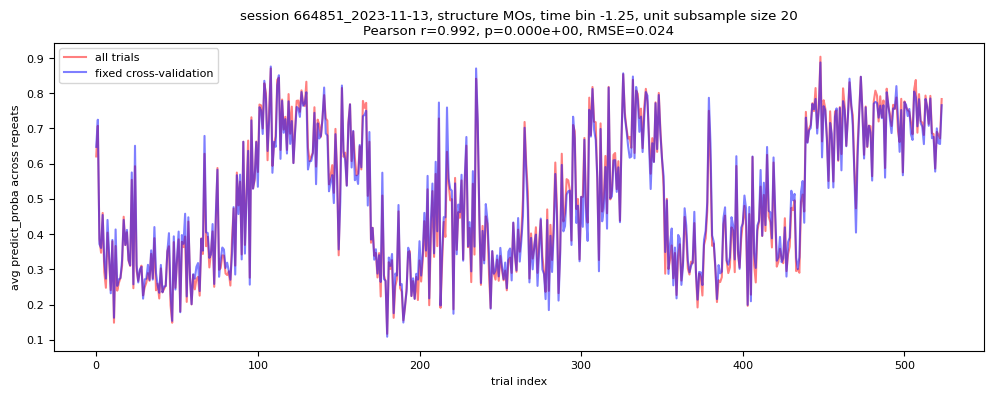

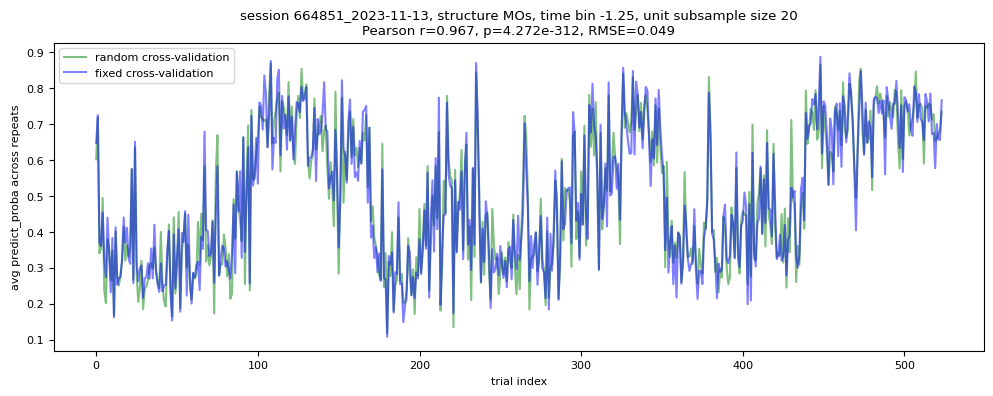

In [180]:
sel_structure='MOs'
sel_time_bin=-1.25
sel_unit_subsample_size=20

if np.isnan(sel_unit_subsample_size):
    filtered_df=predict_proba_with_repeats_single_session_pd_fixed_crossval.query(
        'structure == @sel_structure and bin_center == @sel_time_bin and unit_subsample_size.isna()'
    )
    
else:
    filtered_df=predict_proba_with_repeats_single_session_pd_fixed_crossval.query(
        'structure == @sel_structure and bin_center == @sel_time_bin and unit_subsample_size == @sel_unit_subsample_size'
    )

random_crossval_pd=predict_proba_with_repeats_single_session_pd.query(
    'structure == @sel_structure and bin_center == @sel_time_bin and unit_subsample_size == @sel_unit_subsample_size'
)

all_trials_predict_proba=np.nanmean(np.vstack(filtered_df['predict_proba_all_trials'].values), axis=0)
fixed_crossval_predict_proba=np.nanmean(np.vstack(filtered_df['predict_proba'].values), axis=0)
random_crossval_predict_proba=np.nanmean(np.vstack(random_crossval_pd['predict_proba'].values), axis=0)

r,p=stats.pearsonr(
    all_trials_predict_proba,
    fixed_crossval_predict_proba
)
rmse = np.sqrt(np.mean((all_trials_predict_proba - fixed_crossval_predict_proba)**2))
fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(all_trials_predict_proba, color='red', alpha=0.5, label='all trials')
ax.plot(fixed_crossval_predict_proba, color='blue', alpha=0.5, label='fixed cross-validation')
# ax.plot(random_crossval_predict_proba, color='green', alpha=0.5, label='random cross-validation')
ax.set_ylabel('avg predict_proba across repeats')
ax.set_xlabel('trial index')
ax.set_title(f'session {sel_session}, structure {sel_structure}, time bin {sel_time_bin}, unit subsample size {sel_unit_subsample_size}\nPearson r={r:.3f}, p={p:.3e}, RMSE={rmse:.3f}')
ax.legend()

r,p=stats.pearsonr(
    random_crossval_predict_proba,
    fixed_crossval_predict_proba
)
rmse = np.sqrt(np.mean((random_crossval_predict_proba - fixed_crossval_predict_proba)**2))
fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(random_crossval_predict_proba, color='green', alpha=0.5, label='random cross-validation')
ax.plot(fixed_crossval_predict_proba, color='blue', alpha=0.5, label='fixed cross-validation')
ax.set_ylabel('avg predict_proba across repeats')
ax.set_xlabel('trial index')
ax.set_title(f'session {sel_session}, structure {sel_structure}, time bin {sel_time_bin}, unit subsample size {sel_unit_subsample_size}\nPearson r={r:.3f}, p={p:.3e}, RMSE={rmse:.3f}')
ax.legend()

In [ ]:
#correlation between each repeat?



In [89]:
all_trials=pl.read_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet')

In [60]:
predict_proba_with_repeats_single_session_pd['structure'].unique()

array(['ACAd', 'ACAv', 'CP', 'GU', 'ILA', 'LSr', 'MOs', 'ORBl', 'ORBm',
       'ORBvl', 'PL', 'SSp', 'SSs', 'TTd', 'VISal'], dtype=object)

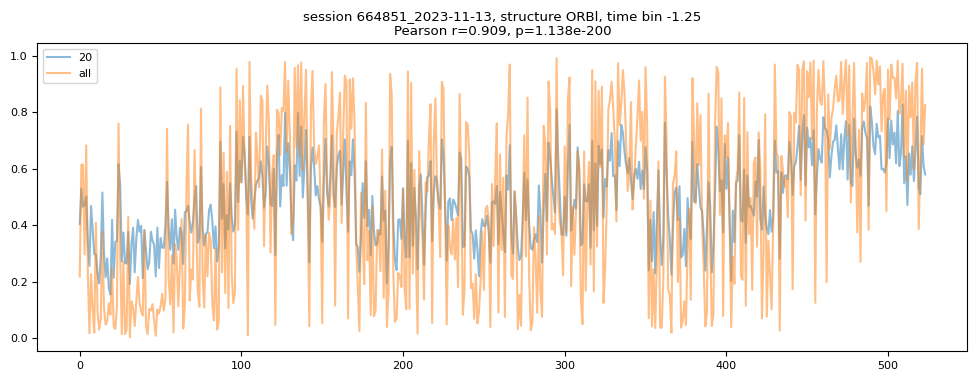

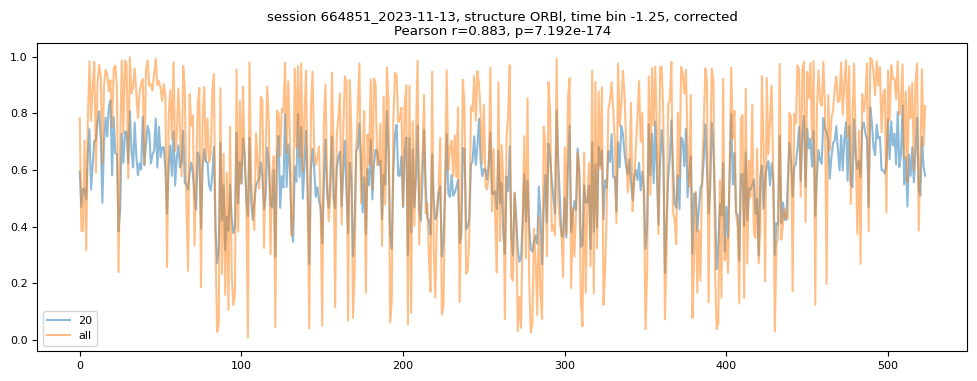

In [157]:
#compare subsample sizes 20 and all
sel_structure='ORBl'
sel_time_bin=-1.25
compare_subsample_sizes=[20,np.nan]

session_trials=all_trials.filter(pl.col('session_id').eq(sel_session)).sort('trial_index')

filtered_df_list=[]
for sel_unit_subsample_size in compare_subsample_sizes:
    if np.isnan(sel_unit_subsample_size):
        filtered_df=predict_proba_with_repeats_single_session_pd_fixed_crossval.query(
            'structure == @sel_structure and bin_center == @sel_time_bin and unit_subsample_size.isna()'
        )
        
    else:
        filtered_df=predict_proba_with_repeats_single_session_pd_fixed_crossval.query(
            'structure == @sel_structure and bin_center == @sel_time_bin and unit_subsample_size == @sel_unit_subsample_size'
        )
    filtered_df_list.append(filtered_df)

# subsample_20 = np.nanmean(np.vstack(filtered_df_list[0]['predict_proba_all_trials'].values),axis=0)
# all_units = np.nanmean(np.vstack(filtered_df_list[1]['predict_proba_all_trials'].values),axis=0)

subsample_20 = np.nanmean(np.vstack(filtered_df_list[0]['predict_proba'].values),axis=0)
all_units = np.nanmean(np.vstack(filtered_df_list[1]['predict_proba'].values),axis=0)

subsample_20_corrected = []
all_units_corrected = []
correction='flip_aud' #or 'subtract_mean'
for bb in session_trials['block_index'].unique():
    block_trials=session_trials.to_pandas().query(f'block_index=={bb}')
    if correction=='flip_aud':
        if block_trials['rewarded_modality'].values[0]=='vis':
            subsample_20_corrected.append(subsample_20[block_trials.index.values])
            all_units_corrected.append(all_units[block_trials.index.values])
        elif block_trials['rewarded_modality'].values[0]=='aud':
            subsample_20_corrected.append(1 - subsample_20[block_trials.index.values])
            all_units_corrected.append(1 - all_units[block_trials.index.values])
    elif correction=='subtract_mean':
        subsample_20_corrected.append(subsample_20[block_trials.index.values] - np.nanmean(subsample_20[block_trials.index.values]))
        all_units_corrected.append(all_units[block_trials.index.values] - np.nanmean(all_units[block_trials.index.values]))

subsample_20_corrected = np.concatenate(subsample_20_corrected)
all_units_corrected = np.concatenate(all_units_corrected)

r,p=stats.pearsonr(
    subsample_20,
    all_units
)

rcorr,pcorr=stats.pearsonr(
    subsample_20_corrected,
    all_units_corrected
)

fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(subsample_20,label=f'20',alpha=0.5)
ax.plot(all_units,label=f'all',alpha=0.5)
ax.set_title(f'session {sel_session}, structure {sel_structure}, time bin {sel_time_bin}\nPearson r={r:.3f}, p={p:.3e}')
ax.legend()

fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(subsample_20_corrected,label=f'20',alpha=0.5)
ax.plot(all_units_corrected,label=f'all',alpha=0.5)
ax.set_title(f'session {sel_session}, structure {sel_structure}, time bin {sel_time_bin}, corrected\nPearson r={rcorr:.3f}, p={pcorr:.3e}')
ax.legend()



In [ ]:
#example correlation between areas, for each subsample size



In [181]:
#correlation between areas - 20 vs all units
sel_time_bin=-1.25
compare_subsample_sizes=[20]
sel_repeat_idx=0
all_trials_flag=False
excl_instruction_trials=True

predict_proba_corr_dict={
    'session_id':[],
    'structure_0':[],
    'structure_1':[],
    'r':[],
    'p':[],
    'unit_subsample_size':[],
}

# sel_structure_0='ACAd'
# sel_structure_1='ORBl'

session_structures=predict_proba_with_repeats_single_session_pd.query(f'session_id=="{sel_session}"')['structure'].unique()

for sel_unit_subsample_size in compare_subsample_sizes:
    session_trials=all_trials.filter(pl.col('session_id').eq(sel_session)).sort('trial_index').to_pandas()
    
    for sel_structure in session_structures:

        structure_results=predict_proba_with_repeats_single_session_pd.query(
            'structure == @sel_structure and bin_center == @sel_time_bin and unit_subsample_size == @sel_unit_subsample_size' if not np.isnan(sel_unit_subsample_size) else
            'structure == @sel_structure and bin_center == @sel_time_bin and unit_subsample_size.isna()'
        )
        if all_trials_flag:
            predict_proba=np.nanmean(np.vstack(structure_results['predict_proba_all_trials'].values),axis=0)
        else:
            predict_proba=np.nanmean(np.vstack(structure_results['predict_proba'].values),axis=0)

        if len(predict_proba)!=len(session_trials):
            print(f"Skipping {sel_session}, {sel_structure} due to mismatch in number of trials between trials and predict_proba")
            predict_proba=np.array([np.nan]*len(session_trials))

        temp_combined_trials=session_trials.copy()
        temp_combined_trials['predict_proba']=predict_proba

        corrected_predict_proba = []
        for bb in temp_combined_trials['block_index'].unique():
            block_trials=temp_combined_trials.query(f'block_index=={bb}')
            if correction=='flip_aud':
                if block_trials['rewarded_modality'].values[0]=='vis':
                    corrected_predict_proba.append(block_trials['predict_proba'].values)
                elif block_trials['rewarded_modality'].values[0]=='aud':
                    corrected_predict_proba.append(1 - block_trials['predict_proba'].values)
            elif correction=='subtract_mean':
                corrected_predict_proba.append(block_trials['predict_proba'].values - np.nanmean(block_trials['predict_proba'].values))

        corrected_predict_proba = np.concatenate(corrected_predict_proba)
        session_trials[f'{sel_structure}_predict_proba']=corrected_predict_proba

    if excl_instruction_trials:
        session_trials=session_trials.query('~is_instruction').reset_index(drop=True)

    for col0 in session_trials.filter(like='predict_proba').columns:
        for col1 in session_trials.filter(like='predict_proba').columns:
            if col0!=col1:
                r,p=stats.pearsonr(session_trials[col0], session_trials[col1])
                # print(f"{col0} vs {col1}: r={r:.3f}, p={p:.3e}")
                predict_proba_corr_dict['session_id'].append(sel_session)
                predict_proba_corr_dict['structure_0'].append(col0.replace('_predict_proba',''))
                predict_proba_corr_dict['structure_1'].append(col1.replace('_predict_proba',''))
                predict_proba_corr_dict['r'].append(r)
                predict_proba_corr_dict['p'].append(p)
                predict_proba_corr_dict['unit_subsample_size'].append(sel_unit_subsample_size)

predict_proba_corr_df=pd.DataFrame(predict_proba_corr_dict)
predict_proba_corr_df

,session_id,structure_0,structure_1,r,p,unit_subsample_size
0,664851_2023-11-13,ACAd,ACAv,0.532999,1.325384e-37,20
1,664851_2023-11-13,ACAd,CP,0.598607,2.375416e-49,20
2,664851_2023-11-13,ACAd,FRP,0.391484,1.530428e-19,20
3,664851_2023-11-13,ACAd,ILA,0.355864,3.405824e-16,20
4,664851_2023-11-13,ACAd,MOs,0.654409,1.026209e-61,20
...,...,...,...,...,...,...
235,664851_2023-11-13,VPM,RSPv,0.432479,6.212200e-24,20
236,664851_2023-11-13,VPM,SCig,0.565454,4.363438e-43,20
237,664851_2023-11-13,VPM,SSp,0.721602,1.330306e-80,20
238,664851_2023-11-13,VPM,VISam,0.118319,8.479572e-03,20


In [182]:
sel_0='ACAd'
sel_1='MOs'

predict_proba_corr_df.query('structure_0==@sel_0 and structure_1==@sel_1')

,session_id,structure_0,structure_1,r,p,unit_subsample_size
4,664851_2023-11-13,ACAd,MOs,0.654409,1.026209e-61,20


In [183]:
#make heatmap for each unit_subsample_size

# unique_combos=predict_proba_corr_df[['structure_0','structure_1']].drop_duplicates().reset_index(drop=True)

# mean_corr_all={}

# for sel_unit_subsample_size in compare_subsample_sizes:
#     mean_corr=unique_combos.copy()
#     mean_corr['mean_r']=np.nan
#     mean_corr['n_sessions']=0
#     for rr in range(len(unique_combos)):
#         sel_structure_0=unique_combos.loc[rr,'structure_0']
#         sel_structure_1=unique_combos.loc[rr,'structure_1']
#         if np.isnan(sel_unit_subsample_size):
#             temp_df=predict_proba_corr_df.query(f'structure_0==@sel_structure_0 and structure_1==@sel_structure_1 and unit_subsample_size.isna()')
#         else:
#             temp_df=predict_proba_corr_df.query(f'structure_0==@sel_structure_0 and structure_1==@sel_structure_1 and unit_subsample_size==@sel_unit_subsample_size')
#         mean_corr.loc[rr,'mean_r']=temp_df['r'].mean()
#         mean_corr.loc[rr,'n_sessions']=len(temp_df)
#     mean_corr_all[sel_unit_subsample_size]=mean_corr

unique_structures=predict_proba_corr_df['structure_0'].sort_values().unique()
unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a', 'MB'])]

incl_structures=[]
for st in unique_structures:
    if (predict_proba_corr_df[['structure_0','structure_1']].value_counts()[st]>=1).sum()>=1:
        incl_structures.append(st)

incl_structures=np.sort(incl_structures)

corr_matrix={}

#build correlation matrix from this dataframe
for sel_unit_subsample_size in compare_subsample_sizes:
    corr_matrix[sel_unit_subsample_size]=np.full((len(incl_structures), len(incl_structures)), np.nan)
    for rr, sel_structure_0 in enumerate(incl_structures):
        for cc, sel_structure_1 in enumerate(incl_structures):
            if sel_structure_0==sel_structure_1:
                corr_matrix[rr,cc]=np.nan
            else:
                if np.isnan(sel_unit_subsample_size):
                    temp_df=predict_proba_corr_df.query(f'structure_0=="{sel_structure_0}" and structure_1=="{sel_structure_1}" and unit_subsample_size.isna()')
                else:
                    temp_df=predict_proba_corr_df.query(f'structure_0=="{sel_structure_0}" and structure_1=="{sel_structure_1}" and unit_subsample_size==@sel_unit_subsample_size')
                #only save if at least 3 sessions
                if len(temp_df)>=1:
                    corr_matrix[sel_unit_subsample_size][rr,cc]=temp_df['r'].mean()


KeyError: nan

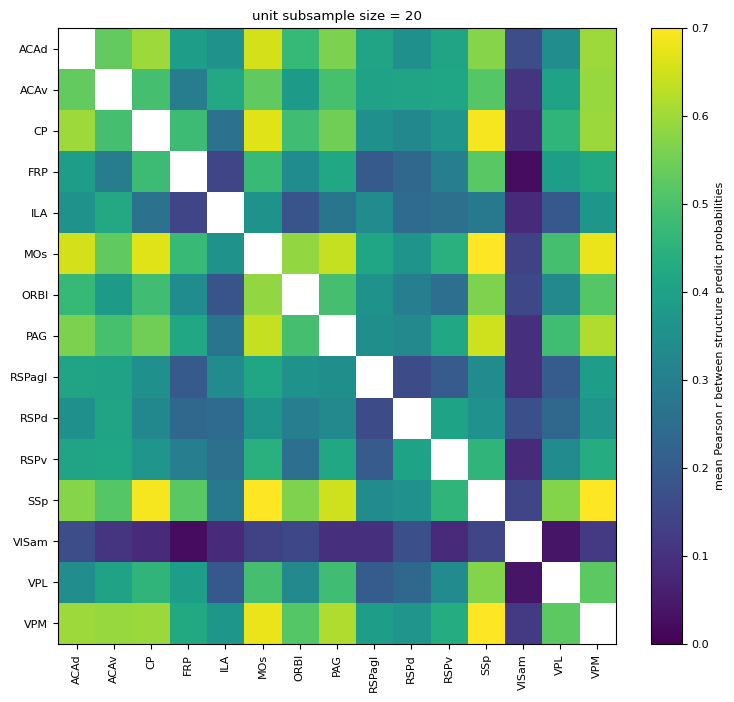

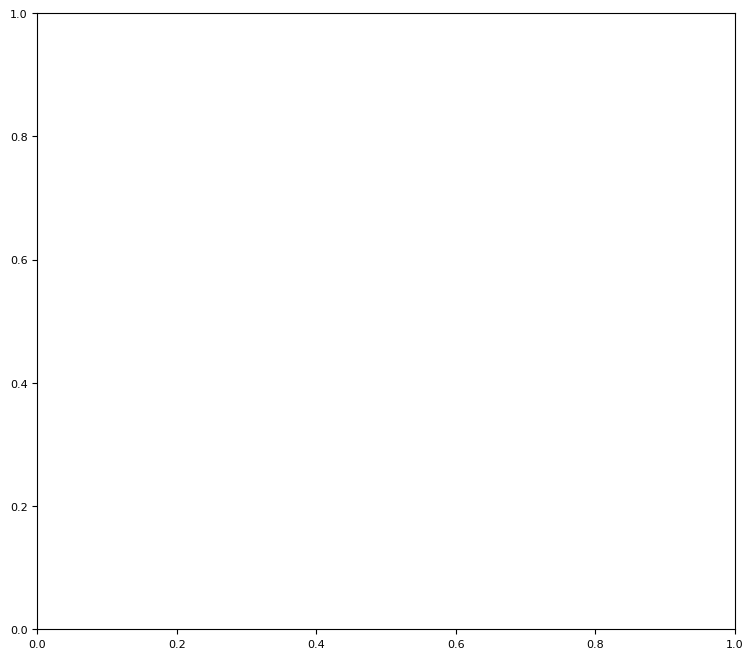

In [184]:
# mean_corr_all[20]

fig,ax=plt.subplots(1,1,figsize=(9,8))
im=ax.imshow(corr_matrix[20], aspect='auto', cmap='viridis', vmin=0, vmax=0.7, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), incl_structures, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), incl_structures)

ax.set_title('unit subsample size = 20')

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')

fig,ax=plt.subplots(1,1,figsize=(9,8))
im=ax.imshow(corr_matrix[np.nan], aspect='auto', cmap='viridis', vmin=0, vmax=0.7, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), incl_structures, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), incl_structures)

ax.set_title('unit subsample size = all')

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')


In [192]:
sessions=['664851_2023-11-15','668755_2023-08-31']

session_table.filter(pl.col('session_id')=='759434_2025-02-04')['areas_recorded'][0]


'ACAd;CA1;CA3;CP;DG;DP;ILA;MOs;OLF;PL;SSp;STR;TEa;TTd;VISl;VISli;ccb;out of brain;scwm'

In [ ]:
#correlation between repeats (with some bounds on number of shared units, restrict to the same probe if possible)